In [1]:
using Pkg
Pkg.activate("..")
using Revise
using Gen
using DataFrames
using Logging
using Plots

  Activating project at `~/src/mit/BayesAir.jl`


In [64]:
using BayesAir

In [163]:
global_logger(ConsoleLogger(stderr, Logging.Info));

In [164]:
# Hyperparams
top_N = 2

# Load data and preprocess
df = BayesAir.load_all_data()
df = BayesAir.remap_columns(df)
filtered_df = BayesAir.top_N_df(df, top_N)
nominal_df, disrupted_df = BayesAir.split_nominal_disrupted_data(filtered_df)
nominal_dfs = BayesAir.split_by_date(nominal_df)
disrupted_dfs = BayesAir.split_by_date(disrupted_df)

println("Top-", top_N, " network has airports: ", unique(filtered_df[!, :destination]))
println("Top-", top_N, " network had " , size(nominal_dfs[1], 1), " flights on day 1")

Top-2 network has airports: InlineStrings.String3["DEN", "MDW"]
Top-2 network had 14 flights on day 1


In [166]:
# Load the nominal days into a schedule object
days = 1
starting_aircraft = 100
states = Vector{BayesAir.NetworkState}()
for i in 1:days
    flights, airports = BayesAir.parse_schedule(nominal_dfs[i] |> DataFrame)

    for _ in 1:starting_aircraft
        for airport_idx in 1:length(airports)
            push!(airports[airport_idx].available_aircraft, 1.0)
            push!(airports[airport_idx].available_crew, 1.0)
        end
    end

    airport_dict = Dict{String, BayesAir.Airport}()
    for airport in airports
        airport_dict[airport.code] = airport
    end

    state = BayesAir.NetworkState(airport_dict, flights |> Vector{BayesAir.Flight})
    push!(states, state)
end
nominal_dfs[1]

Row,destination,scheduled_arrival_time,actual_departure_time,scheduled_departure_time,actual_arrival_time,date,flight_number,origin
,String3,Float64,Float64,Float64,Float64,DateTime,String,String3
1,MDW,8.33333,4.98333,5.0,8.11667,2022-12-01T00:00:00,2810,DEN
2,DEN,7.5,5.61667,5.66667,7.2,2022-12-01T00:00:00,3243,MDW
3,MDW,10.0833,6.61667,6.66667,9.7,2022-12-01T00:00:00,1569,DEN
4,DEN,8.91667,7.15,7.16667,8.63333,2022-12-01T00:00:00,2172,MDW
5,MDW,12.9167,9.45,9.5,12.55,2022-12-01T00:00:00,944,DEN
6,DEN,11.5833,9.78333,9.83333,11.2,2022-12-01T00:00:00,4188,MDW
7,DEN,12.5,10.6333,10.75,12.0167,2022-12-01T00:00:00,2314,MDW
8,MDW,15.5,12.1833,12.1667,15.25,2022-12-01T00:00:00,178,DEN
9,DEN,16.3333,14.75,14.6667,16.1333,2022-12-01T00:00:00,1626,MDW


In [242]:
test_df = nominal_dfs[1]
# Compute the mean difference between actual arrival and departure times for each origin-destination pair
mean_travel_times = Dict{Tuple{String, String}, Float64}()
for row in eachrow(test_df)
    origin = row[:origin]
    destination = row[:destination]
    if !haskey(mean_travel_times, (origin, destination))
        mean_travel_times[(origin, destination)] = 0.0
    end
    mean_travel_times[(origin, destination)] += row[:actual_arrival_time] - row[:actual_departure_time]
end
for key in keys(mean_travel_times)
    mean_travel_times[key] /= size(test_df[(test_df[!, :origin] .== key[1]) .& (test_df[!, :destination] .== key[2]), :], 1)
end
mean_travel_times

Dict{Tuple{String, String}, Float64} with 2 entries:
  ("MDW", "DEN") => 1.46429
  ("DEN", "MDW") => 3.1619

In [243]:
# Trace the simulation using Gen and see the random choices made by the simulator
hrs = 30.0
dt = 0.1
trace = Gen.simulate(BayesAir.simulate, (states, hrs, dt));
Gen.get_choices(trace)

│
├── ("DEN", :log_mean_service_time) : 0.3264362553425567
│
├── ("DEN", :log_mean_turnaround_time) : 0.0023187677917085843
│
├── :log_travel_time_variation : -0.30958456205390233
│
├── ("MDW", :log_mean_turnaround_time) : 1.0873409320411538
│
├── :log_turnaround_time_variation : -0.31034658821481953
│
├── ("DEN", "MDW", :log_travel_time) : 1.0917444601958814
│
├── ("MDW", "DEN", :log_travel_time) : 1.0573653415631783
│
├── ("MDW", :log_mean_service_time) : -0.3018001708874908
│
├── :log_measurement_variation : -0.608188078354928
│
└── (:day, 1)
    │
    ├── ("2283 DEN->MDW", :arrival_service_time) : 0.10334993963290891
    │
    ├── ("2172 MDW->DEN", :arrival_service_time) : 0.08718505922888865
    │
    ├── ("1569 DEN->MDW", :turnaround_time) : 2.7711480681951675
    │
    ├── ("2810 DEN->MDW", :departure_service_time) : 0.41342303430131033
    │
    ├── ("2810 DEN->MDW", :travel_time) : 8.15909492366021
    │
    ├── ("2283 DEN->MDW", :departure_service_time) : 0.059823856238541986

In [245]:
function render_traces(traces, weights=nothing)
    # For each pair of airports, make a scatter plot of the travel times for each trace
    airport_codes = keys(Gen.get_args(traces[1])[1][1].airports)

    # Aggregate the travel times for each airport pair
    travel_times = Dict{Tuple{String, String}, Vector{Float64}}()
    for origin in airport_codes
        for destination in airport_codes
            if origin != destination
                travel_times[(origin, destination)] = Vector{Float64}()
            end
        end
    end
    for trace in traces
        for origin in airport_codes
            for destination in airport_codes
                if origin != destination
                    push!(travel_times[(origin, destination)], 3.0 * exp(trace[(origin, destination, :log_travel_time)]))
                end
            end
        end
    end

    already_plotted = Set{Tuple{String, String}}()
    figs = Vector{Plots.Plot{Plots.GRBackend}}()
    for (origin, destination) in keys(travel_times)
        if (origin, destination) in already_plotted
            continue
        end
        
        fig = scatter(
            travel_times[(origin, destination)],
            travel_times[(destination, origin)];
            xlabel=origin * " -> " * destination,
            ylabel=destination * " -> " * origin,
            legend=false,
            xlims = (0,6),
            ylims = (0,6)
        )
        push!(already_plotted, (origin, destination))
        push!(already_plotted, (destination, origin))
        push!(figs, fig)
    end

    return figs
end;

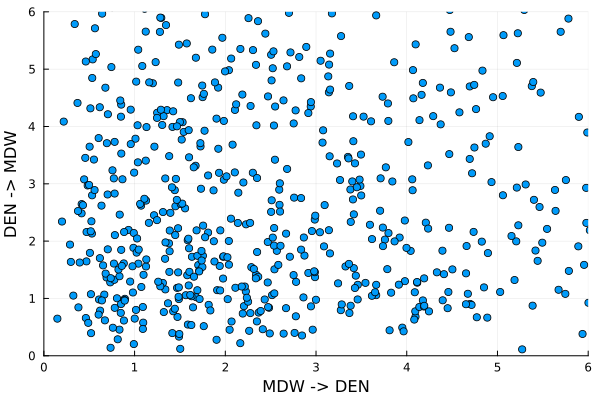

In [248]:
# Render the prior distribution
traces = [Gen.simulate(BayesAir.simulate, (states, hrs, dt)) for _ in 1:1000]
Plots.plot(render_traces(traces)...)

In [216]:
@gen function system_parameter_proposal(trace, width)
    # Resample the system parameters
    # {:measurement_variation} ~ uniform(
    #     max(0.0, trace[:measurement_variation] - width / 2),
    #     trace[:measurement_variation] + width / 2
    # )
    # {:turnaround_time_variation} ~ uniform(
    #     max(0.0, trace[:turnaround_time_variation] - width / 2),
    #     trace[:turnaround_time_variation] + width / 2
    # )
    {:log_measurement_variation} ~ normal(trace[:log_measurement_variation], width)
    {:log_turnaround_time_variation} ~ normal(trace[:log_turnaround_time_variation], width)
end

@gen function airport_parameter_proposal(trace, airport_code::BayesAir.AirportCode, width)
    # Resample the parameters for the given airport
    # {(airport_code, :turnaround_time)} ~ uniform(
    #     max(0.0, trace[(airport_code, :turnaround_time)] - width / 2),
    #     trace[(airport_code, :turnaround_time)] + width / 2
    # )
    # {(airport_code, :service_time)} ~ uniform(
    #     max(0.0, trace[(airport_code, :service_time)] - width / 2),
    #     trace[(airport_code, :service_time)] + width / 2
    # )
    {(airport_code, :log_turnaround_time)} ~ normal(
        trace[(airport_code, :log_turnaround_time)],
        width
    )
    {(airport_code, :log_service_time)} ~ normal(
        trace[(airport_code, :log_service_time)],
        width
    )
end

@gen function all_airport_parameter_proposal(trace, airport_codes, width)
    # Update all airport params
    for airport_code in airport_codes
        {*} ~ airport_parameter_proposal(trace, airport_code, width)
    end

    # Update all flight service and turnaround times
    for (i, state) in enumerate(Gen.get_args(trace)[1])
        for flight in state.pending_flights
            departure_service_key = (:day, i) => (BayesAir.flight_code(flight), :departure_service_time)
            # {departure_service_key} ~ uniform(
            #     max(0.0, trace[departure_service_key] - width / 2),
            #     trace[departure_service_key] + width / 2
            # )
            {departure_service_key} ~ normal(
                trace[departure_service_key],
                width
            )

            # arrival_service_key = (:day, i) => (BayesAir.flight_code(flight), :arrival_service_time)
            # {arrival_service_key} ~ uniform(
            #     max(0.0, trace[arrival_service_key] - width / 2),
            #     trace[arrival_service_key] + width / 2
            # )

            # turnaround_key = (:day, i) => (BayesAir.flight_code(flight), :turnaround_time)
            # {turnaround_key} ~ uniform(
            #     max(0.0, trace[turnaround_key] - width / 2),
            #     trace[turnaround_key] + width / 2
            # )

        end
    end
end

@gen function travel_times_proposal(trace, airport_codes, width)
    # Resample travel time variation
    {:travel_time_variation} ~ uniform(
        max(0.0, trace[:travel_time_variation] - width / 2),
        trace[:travel_time_variation] + width / 2
    )

    # Resample actual travel and service times for all routes
    realized_travel_times = Dict{Tuple{BayesAir.AirportCode, BayesAir.AirportCode}, Float64}()
    realized_travel_time_counts = Dict{Tuple{BayesAir.AirportCode, BayesAir.AirportCode}, Int}()
    for (i, state) in enumerate(Gen.get_args(trace)[1])
        for flight in state.pending_flights
            travel_time_key = (:day, i) => (BayesAir.flight_code(flight), :travel_time)
            realized_travel_time = {travel_time_key} ~ uniform(
                max(0.0, trace[travel_time_key] - width / 2),
                trace[travel_time_key] + width / 2
            )

            # Track the mean travel time for this route
            if !((flight.origin, flight.destination) in keys(realized_travel_times))
                realized_travel_times[(flight.origin, flight.destination)] = 0.0
                realized_travel_time_counts[(flight.origin, flight.destination)] = 0
            end
            realized_travel_times[(flight.origin, flight.destination)] += realized_travel_time
            realized_travel_time_counts[(flight.origin, flight.destination)] += 1
        end
    end

    # Update the mean travel times for all routes
    for (origin_code, destination_code) in keys(realized_travel_times)
        key = (origin_code, destination_code, :travel_time)
        # {key} ~ normal(
        #     realized_travel_times[(origin_code, destination_code)] / realized_travel_time_counts[(origin_code, destination_code)],
        #     trace[:travel_time_variation]
        # )
        {key} ~ uniform(
            max(0.0, trace[key] - width / 2),
            min(trace[key] + width / 2, 6.0)
        )
    end
end

@gen function all_parameters_proposal(trace, airport_codes, width)
    {*} ~ system_parameter_proposal(trace, width)
    {*} ~ all_airport_parameter_proposal(trace, airport_codes, width)
    {*} ~ travel_times_proposal(trace, airport_codes, width)
end

function gaussian_drift_update(trace, width, constraints)
    # Get a list of all airports
    airport_codes = keys(Gen.get_args(trace)[1][1].airports)

    (trace, system_params_accepted) = mh(trace, system_parameter_proposal, (width,), check=true, observations=constraints)
    (trace, airport_params_accepted) = mh(trace, all_airport_parameter_proposal, (airport_codes, width), check=true, observations=constraints)
    (trace, travel_times_accepted) = mh(trace, travel_times_proposal, (airport_codes, width), check=true, observations=constraints)
    
    # (trace, all_accepted) = mh(trace, all_parameters_proposal, (airport_codes, width), check=true, observations=constraints)

    return trace, Dict(
        :system_params => system_params_accepted,
        :airport_params => airport_params_accepted,
        :travel_times => travel_times_accepted,
        # :all => all_accepted
    )
end;

function do_mcmc_inference(model, states, hrs, dt, num_samples, burn_in_samples, width)
    # Make constraints based on actual departure and arrival times
    constraints = Gen.choicemap()
    for (i, state) in enumerate(states)
        for flight in state.pending_flights
            constraints[(:day, i) => (BayesAir.flight_code(flight), :actual_departure_time)] = flight.actual_departure_time
            constraints[(:day, i) => (BayesAir.flight_code(flight), :actual_arrival_time)] = flight.actual_arrival_time
        end
    end

    # Get an initial trace
    (trace, _) = Gen.generate(model, (states, hrs, dt), constraints)

    # Run the burn-in
    for _ in 1:burn_in_samples
        trace, _ = gaussian_drift_update(trace, width, constraints)
    end

    # Run the main loop
    scores = Vector{Float64}()
    traces = Vector{Gen.DynamicDSLTrace}()
    acceptance_rates = Dict()
    for _ in 1:num_samples
        trace, accepted = gaussian_drift_update(trace, width, constraints)
        push!(traces, trace)
        push!(scores, Gen.get_score(trace))

        # Update acceptance rates
        for (key, value) in accepted
            if !haskey(acceptance_rates, key)
                acceptance_rates[key] = 0.0
            end

            acceptance_rates[key] = acceptance_rates[key] + value / num_samples
        end
    end

    return traces, scores, acceptance_rates
end;

average_acceptance_rates = Dict{Any, Any}(:travel_times => 0.023500000000000014, :airport_params => 0.0, :system_params => 0.06600000000000004)


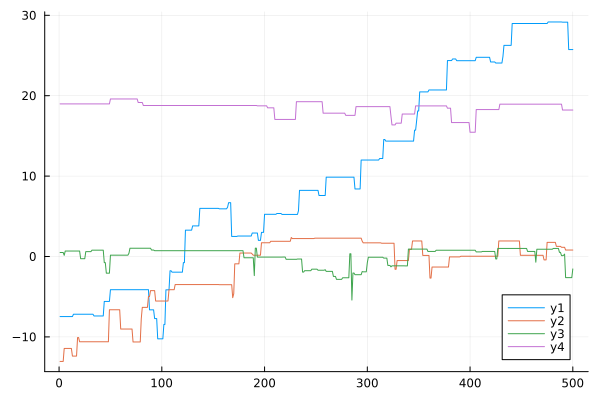

In [233]:
all_traces = Vector{Any}()
trace_figs = Vector{Plots.Plot{Plots.GRBackend}}()
scores = Vector{Vector{Float64}}()
average_acceptance_rates = Dict()
n_chains = 4
stepsize = 1.0
burn_in_samples = 500
samples = 500
n_hours = 50.0
dt = 0.1
for _ in 1:n_chains
    traces, trace_scores, acceptance_rates = do_mcmc_inference(BayesAir.simulate, states, n_hours, dt, samples, burn_in_samples, stepsize)
    push!(all_traces, traces)
    push!(scores, trace_scores)
    for (key, value) in acceptance_rates
        if !haskey(average_acceptance_rates, key)
            average_acceptance_rates[key] = 0.0
        end
        average_acceptance_rates[key] = average_acceptance_rates[key] + value / n_chains
    end
end
@show average_acceptance_rates
Plots.plot([s for s in scores])

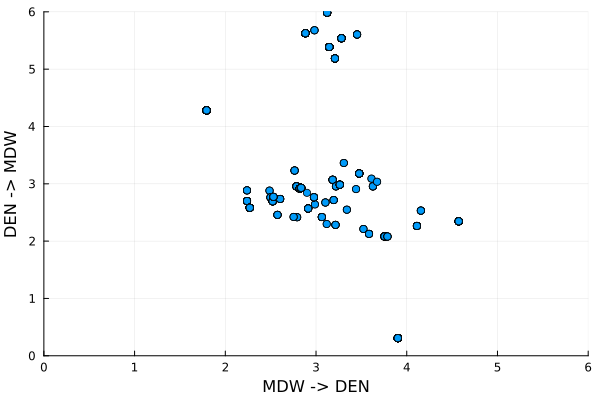

In [234]:
Plots.plot(render_traces(vcat(all_traces...))...)